# FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [1]:
from collections import Counter 
import requests 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.metrics import accuracy_score, roc_auc_score

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

# Ser contribuyente y proveer todos los datos a FIUFIP puede volverse complicado ¿Hay datos que falten en el dataset provisto?


Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales. Esto puede llevar a que haya datos faltantes. Veamos si hay datos faltantes y ya que estamos visualicemos todas las features provistas en el dataset

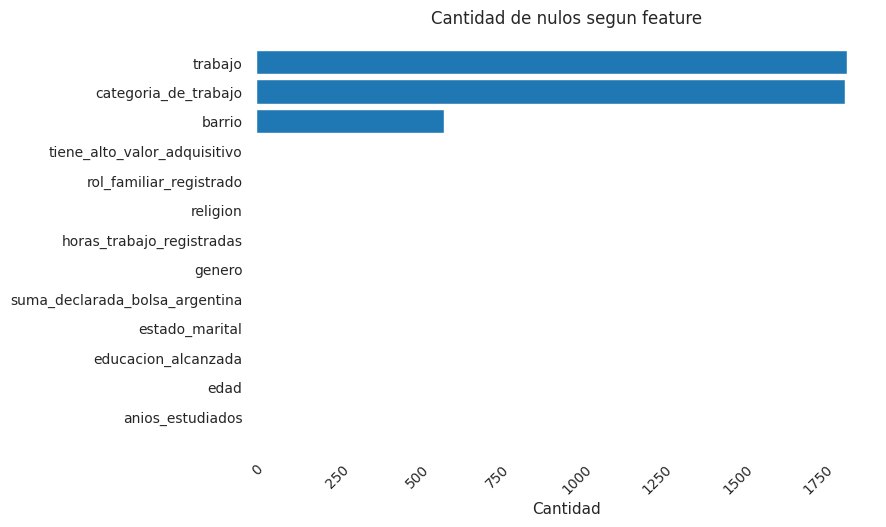

In [4]:
plt.figure(dpi = 100)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina':'suma_declarada_bolsa_argentina'},inplace=True)
nulos = df.isnull().sum().sort_values(ascending = True)


y_pos = np.arange(len(nulos.index))
plt.barh(y_pos, nulos.values, align='center')
plt.yticks(y_pos, nulos.index)
plt.ylabel('')
plt.xlabel('Cantidad')
plt.xticks(rotation = 45)
plt.title('Cantidad de nulos segun feature')
plt.show()

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Resulta llamativo que los nulos en categoria de trabajo y trabajo sean similiares pero primero veamos sucede con la feature barrio 

## ¿Qué sucede y cómo se distribuye la feature barrio? ¿A qué puede deberse su cantidad de valores nulos?

Veamos la cantidad de posibles opciones de barrio que hay en el dataset

In [5]:
len(df.barrio.value_counts().index)


41

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles al momento de obtener los datos. Debido a esto cambiemos el Nan por 'Otro' y veamos la distribución de la feature en cuestión

[]

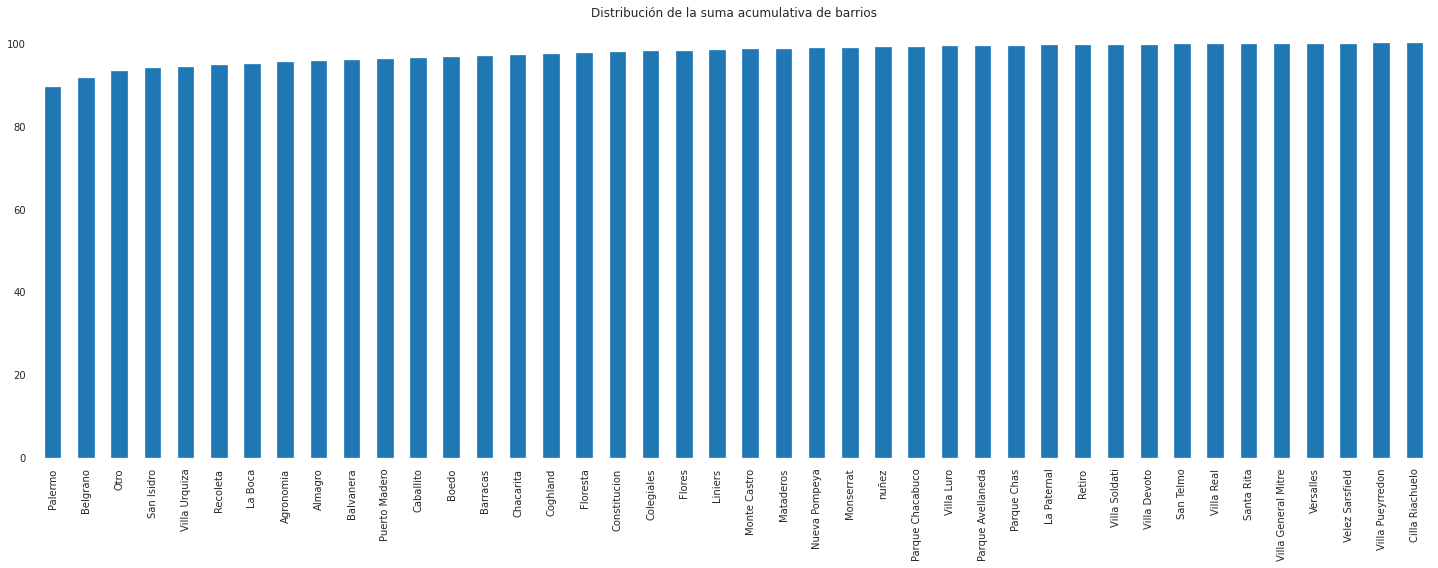

In [6]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')
barrios = df['barrio'].value_counts(normalize=True,dropna=False) * 100

barrios.cumsum().plot(
   kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)

plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. Es decir, que se trata de una feature que además de tener una alta cardinaliad, tiene una baja varianza y a priori parecería dificil poder establecer relaciones con otras variables

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tienen alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. En primer lugar veamos la feature categoria de trabajo

In [7]:
df['categoria_de_trabajo'].value_counts(dropna=False)

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
NaN                         1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Remplacemos el Nan por un 'No contesta' para poder entender mejor los datos, ya que estamos hablando de una variable categorica. Por otra parte,   se observa una distinción entre los distintos tipos de empleado público posible. Reasignemolos a una nueva categoria 'empleado_publico' y veamos la distribución de esta feature

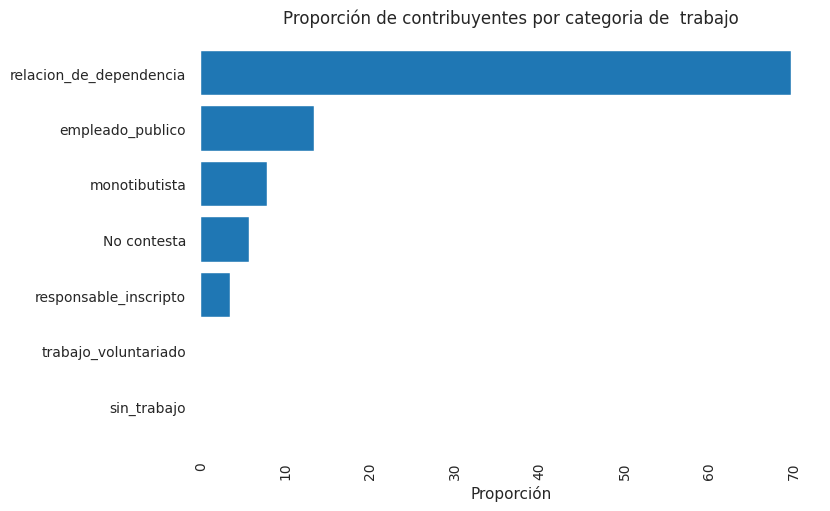

In [8]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].apply(generalizar_empleados_publicos)
plt.figure(dpi = 100)
cantidad_por_trabajo = df['categoria_de_trabajo'].value_counts(normalize=True,ascending=True) * 100
plt.barh(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Proporción de contribuyentes por categoria de  trabajo")
plt.xticks(rotation = 90)
plt.xlabel('Proporción')

plt.show()

Vemos que la gran mayoria de los contribuyentes se encuentra trabajando en el sector privado y en particular casi el 70% lo hace en relación de dependencia. Quizás en un futuro esta información nos sea útil, pero por el momento sigamos adelante. Veamos ahora la feature 'trabajo'

In [9]:
df['trabajo'].value_counts(dropna=False)

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
NaN                          1843
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta' y luego veremos si podemos obtener más información de quienes no contestaron

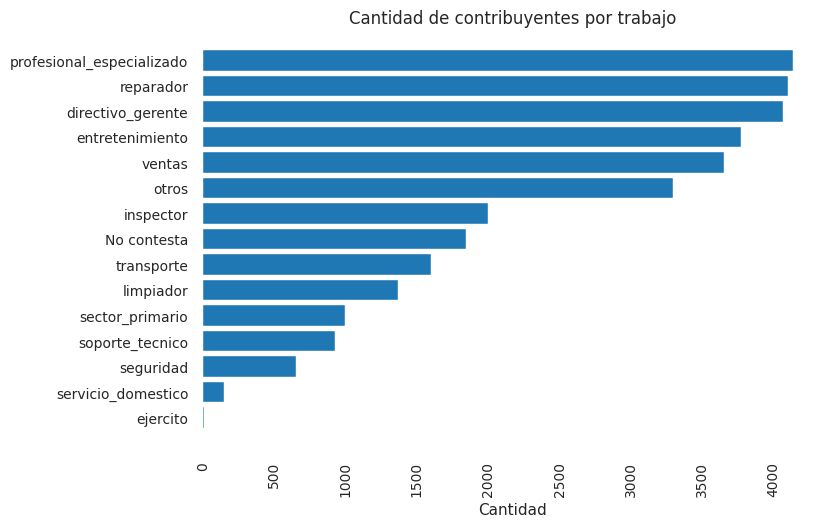

In [10]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
plt.figure(dpi = 100)
cantidad_por_trabajo = df['trabajo'].value_counts(ascending=True)
plt.barh(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por trabajo")
plt.xticks(rotation = 90)
plt.xlabel('Cantidad')

plt.show()

Vemos que hay cinco trabajos predominantes, lo cual por el momento no nos dice mucho

In [11]:
dataset_sin_contestar = df[df['categoria_de_trabajo'] == 'No contesta']
dataset_sin_contestar = dataset_sin_contestar[dataset_sin_contestar['trabajo'] == 'No contesta']
dataset_sin_contestar.shape

(1836, 13)

Se puede ver que trás filtrar el dataset quienes no contestan en la feature 'trabajo', tampoco lo hacen en la feature 'categoria_de_trabajo'. Ahora bien, ¿Se trata esto de un error en la recolección de los datos por parte de nuestra querida agencia? ¿Se tratará de desempleados que erronamente figuran en el dataset? ¿O son desempleados (quizás retirados) que conservan fuentes de ingreso que son gravables? 

## Aquellos de quienes desconocemos su trabajo,  ¿Operan en la bolsa?¿Qué edades tienen? ¿Presentan horas registradas trabajando?

Veamos primero como es la distribución de las edades

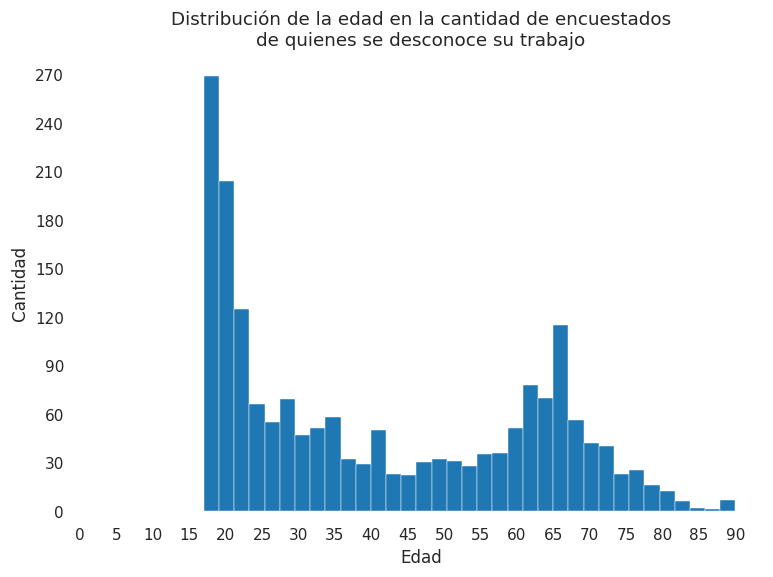

In [12]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.edad.nunique()/2)
plt.hist(dataset_sin_contestar.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados\nde quienes se desconoce su trabajo")
plt.ylabel("Cantidad")
plt.xlabel("Edad")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,300, 30))

plt.show()

No resulta llamativo una cierta concentración a partir de aproximadamente contribuyentes mayores a 60 años (pueden ser jubilados con bienes adicionales que sean gravables), pero ¿como se puede explicar la concentración que vemos en los sub 30? Investiguemos un poco más, quizás hemos identificado a genios del trading, que aún así no lograron evadir las garras de la FIUFIP

### Los menores a 30 años, ¿Tiene alta participación en la bolsa?

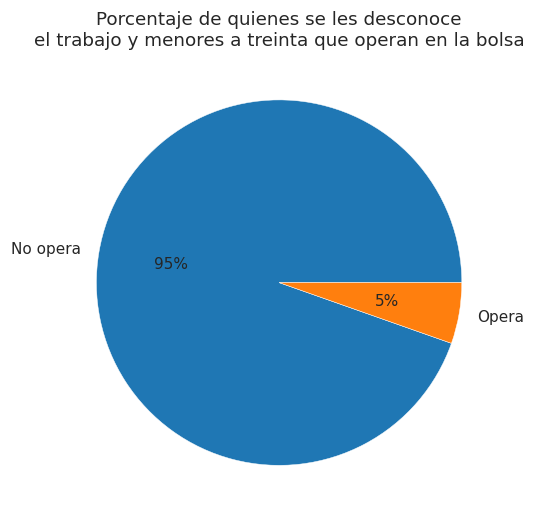

In [13]:
plt.figure(dpi=110)

menores_a_treinta = dataset_sin_contestar[dataset_sin_contestar['edad'] <= 30]
porcentaje_que_opera = (menores_a_treinta['suma_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)
porcentaje_que_opera.plot(kind='pie',autopct='%1.0f%%',labels = ['No opera','Opera'])
plt.title('Porcentaje de quienes se les desconoce\nel trabajo y menores a treinta que operan en la bolsa')
plt.ylabel('')
plt.show()


Bueno, pareciera que no se trata particularmente de genios de las finanzas, o al menos no de gente que tiene interés en comunicarlo. Veamos que sucede con las horas de trabajo registradas

### ¿Como es la distribución de horas trabajadas de estas personas?¿Y si es gente que esta desempleada y figura por error?

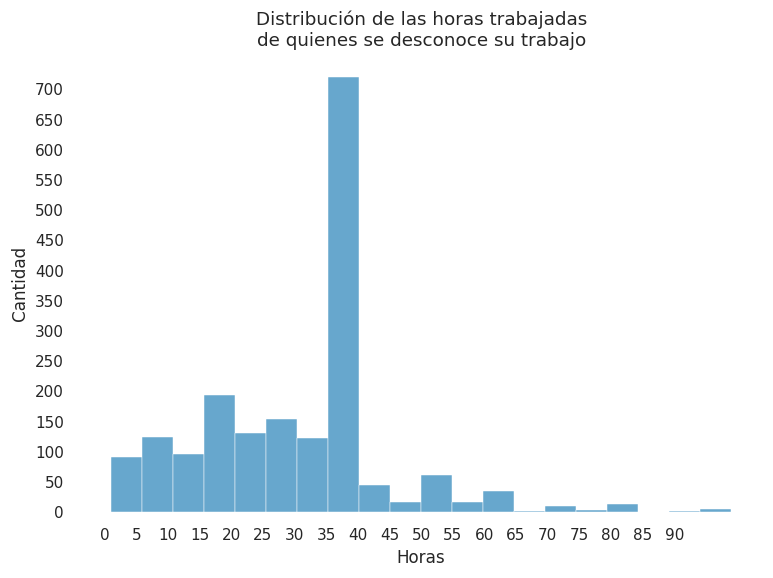

In [14]:
plt.figure(dpi=110)

sns.histplot(
    data=dataset_sin_contestar,
    x='horas_trabajo_registradas',
    bins=20
)

plt.title("Distribución de las horas trabajadas\nde quienes se desconoce su trabajo")
plt.ylabel("Cantidad")
plt.xlabel("Horas")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,750, 50))
plt.show()

Los datos resultan concluyentes. No parece tratarse de desempleados (a menos que acaben de perder el empleo y estos datos aún no se hayan actualizado) sino más bien gente de la que realmente no se pudo obtener información. Habrá que mejorar la recolección de datos hecha por FIUFIP. 

# Se puede mentir con la Edad en las redes o en persona pero, ¿Y a la FIUFIP?

Resulta de interés observar la distribución de edades de los contribuyentes. Reagrupemos en rangos y observemos

Primero verifiquemos que todas las edades tengan sentido

In [15]:
(df.edad < 10).any()

False

Es decir, no hay ninguna edad incongruente.

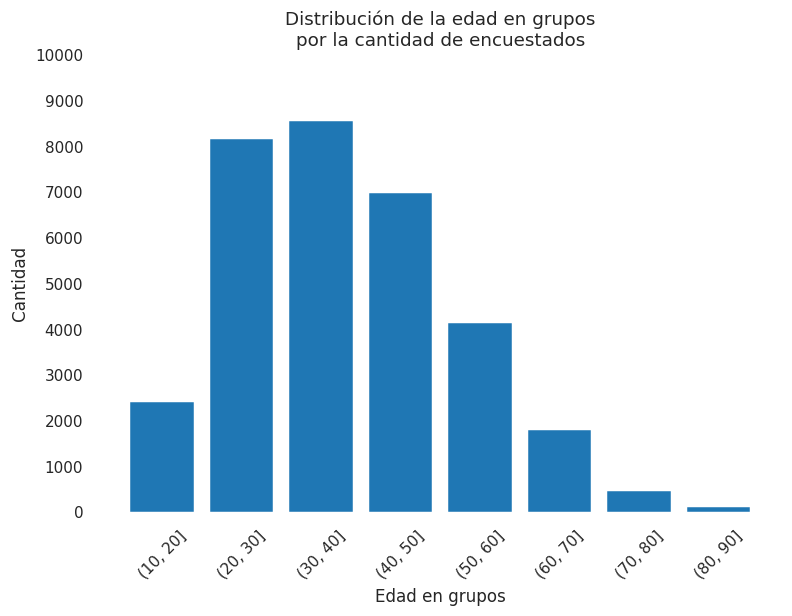

In [16]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(10,100,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

plt.title("Distribución de la edad en grupos\npor la cantidad de encuestados")
plt.ylabel("Cantidad")
plt.xlabel("Edad en grupos")
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,11000, 1000))
plt.show()

Justo como lo sospechabamos, hay una mayor cantidad de contribuyentes en el rango de los 20 años a los 50 años. Era esperable, se trata de los años donde la gran mayoria de las personas realiza su vida profesional. 

## Edad y horas trabajadas ¿Una evidente relación?

Antes de analizar la relación veamos...

### ¿Cuantas horas trabaja la gente en general?

Observemos

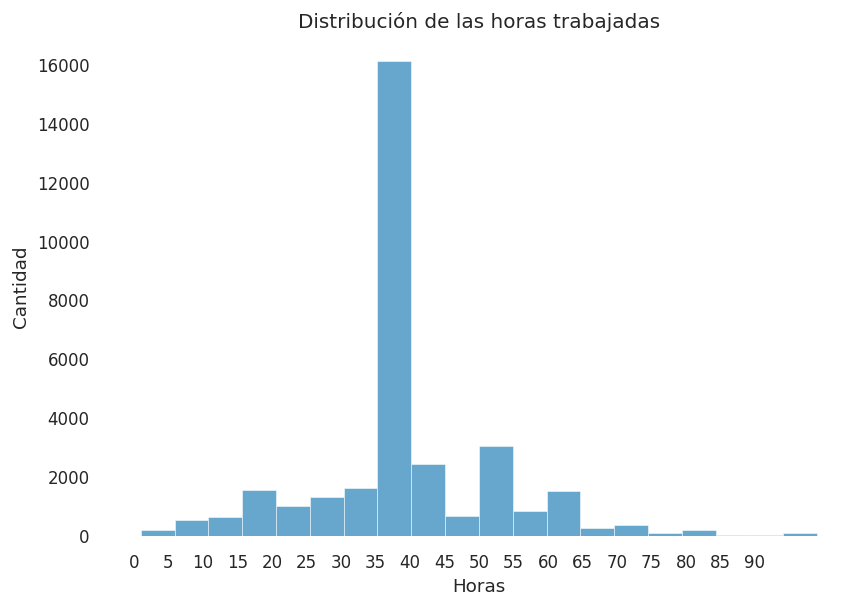

In [17]:
plt.figure(dpi=120)
plt.title("Distribución de las horas trabajadas")
sns.histplot(
    data=df,
    x='horas_trabajo_registradas',
    bins=20
)

plt.ylabel("Cantidad")
plt.xlabel("Horas")
plt.xticks(np.arange(0,95, 5))
plt.show()

Se observa una gran concentración de personas que trabaja alrededor de 40 horas. Dichas hora son claramente semanales y este valor es lógico ya que lo habitual es trabajar 5 dias y 8 horas por día

### Ahora si, ¿Se trabaja menos con el paso del tiempo?

La lógica indica que con el paso de los años, se tiende a trabajar menos. O al menos esperamos que sea así. Veamos si hallamos una relación

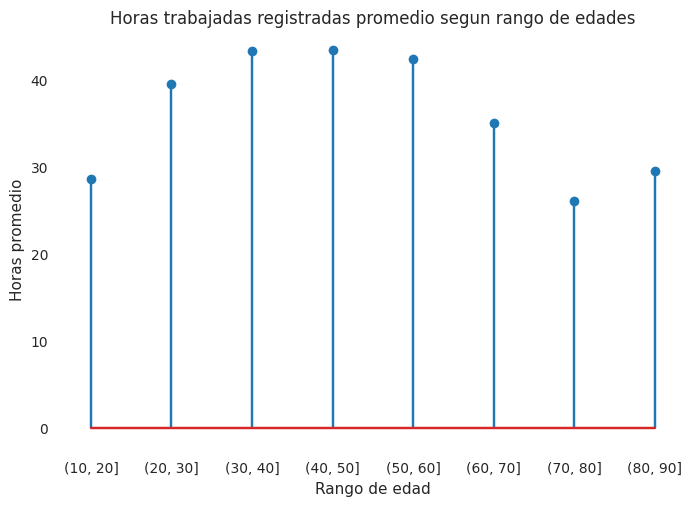

In [18]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))
pf = pf.groupby('rango').agg(list)
pf['horas_trabajadas_promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)

plt.figure(dpi=100)
plt.stem(pf['horas_trabajadas_promedio'],use_line_collection=True)
plt.title('Horas trabajadas registradas promedio segun rango de edades')
plt.xticks(np.arange(0,8,1),pf.index)
plt.xlabel('Rango de edad')
plt.ylabel('Horas promedio')
plt.show()


Nuestra sospecha fue confirmada, al avanzar la edad, las horas de trabajo promedio tienden a ser menos. Además observamos que los menores a 20 años tambien trabajan menos horas en promedio, probablemente porque muchos pueden estar estudiando y se insertan en el mercado laboral en trabajos de menor carga horaria. Sigamos analizando un poco más...

## ¿Hay un rango de Edades que dé indicios de tener alto valor adquisitivo?

Bueno, llegamos a quizás la feature más importante y de la que hablaremos mucho. Hagamos una breve introducción

### ¿Que porcentaje de contribuyentes califican como de altos y bajos ingresos?

Grafiquemos

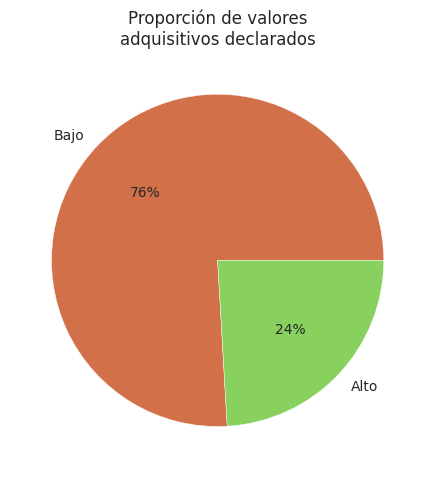

In [19]:
plt.figure(dpi=100)
valor_adquisitivo = df.tiene_alto_valor_adquisitivo.value_counts()
valor_adquisitivo.plot(kind='pie',labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title("Proporción de valores\nadquisitivos declarados")
plt.ylabel('')
plt.show()

Vemos que solo el 24% de los contribuyentes califica como de altos ingresos. Este dato sera importante ya que muchas veces dividiremos a los contribuyentes segun su categoria de ingresos. Pero no nos desviemos aún

### Retomando... ¿Influye la edad en tener altos o bajos ingresos?

Veamos si podemos encontrar una relación

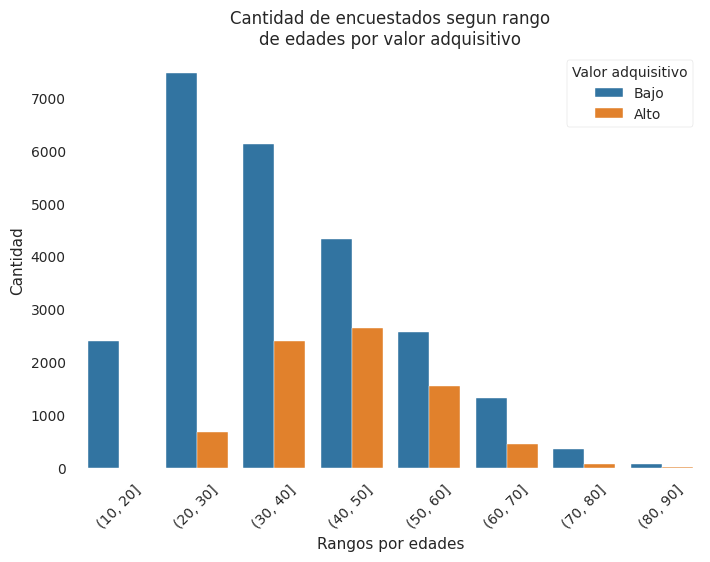

In [20]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))

plt.figure(dpi = (100))
sns.countplot(
   data=pf, x='rango', hue='tiene_alto_valor_adquisitivo'
)

plt.legend(labels=['Bajo', 'Alto'], title='Valor adquisitivo')
plt.ylabel("Cantidad")
plt.xlabel("Rangos por edades")
plt.title("Cantidad de encuestados segun rango\nde edades por valor adquisitivo")
plt.xticks(rotation=45)
plt.show()

Lo que se observa en el gráfico es que en los rangos de edad de entre 30 y 60 años es donde más probabilidad hay de calificar como de altos ingresos. Los menores a 30 años de altos ingresos son muy escasos

## Los trabajos mejor pagos, ¿Solo alcanzables a partir de cierta edad?

No nos apresuremos. Ya habiamos visto la distribución de los trabajos declarados. Veamos ahora cuales son los más propensos a tener altos ingresos

### ¿De que hay que trabajar para tener altos ingresos?

Más de uno se lo preguntó a la hora de elegir su carrera o más de uno se lo pregunta cuando ve su recibo de sueldo. No demos más vueltas, respondamos con un gráfico

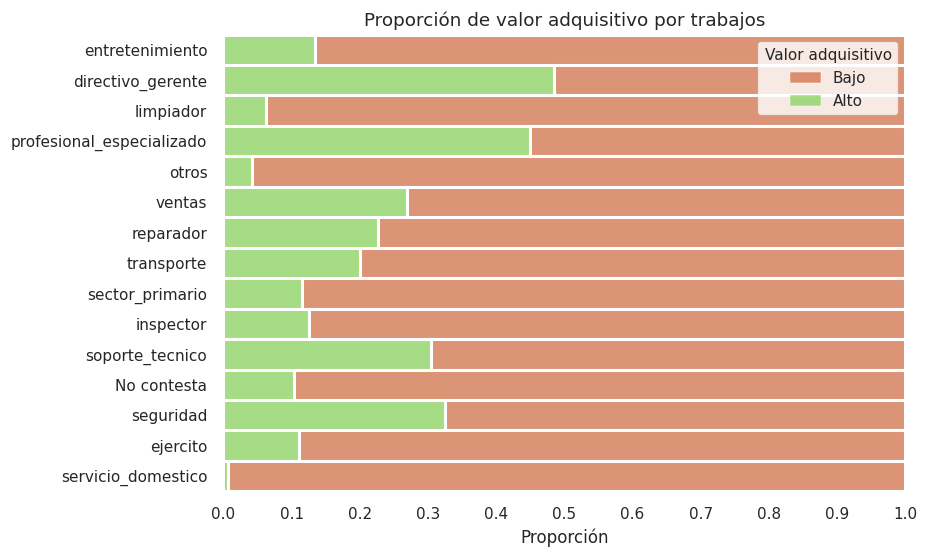

In [21]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='trabajo',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
   edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por trabajos')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

Bueno...pareciera ser que ser gerente o directivo es el camino. También ser un profesional especializado o dedicarse al sector de la seguridad o el soporte técnico. Veamos de que trabajan los jovenes

### ¿Hay muchos menores a 30 gerentes? ¿Y profesionales?

Veamos que sucede con los trabajos que declaran los menores a 30 años

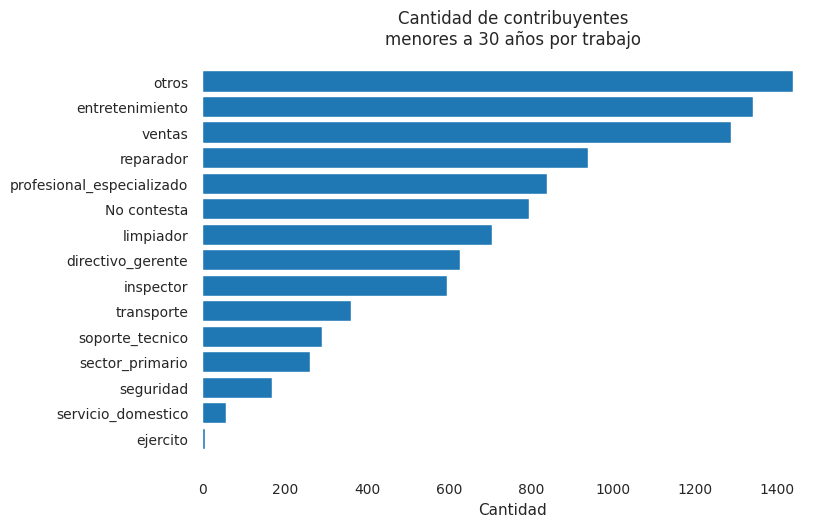

In [22]:
plt.figure(dpi = 100)
jovenes = df[(df.edad < 30)]
jovenes = jovenes['trabajo'].value_counts(ascending=True)

y_pos = np.arange(len(jovenes.index))
plt.barh(y_pos, jovenes.values, align='center')
plt.yticks(y_pos, jovenes.index)
plt.xlabel('Cantidad')
plt.title('Cantidad de contribuyentes\nmenores a 30 años por trabajo')
plt.show()

Vemos en el gráfico que resulta muy complicado para los jóvenes alcanzar puestos jerárquicos. También, es probable que no haya gran cantidad de profesionales especializados porque aún muchos se encuentran estudiando

Bueno, dejemos a la edad tranquila, hablemos de algo que viene pisando fuerte en los últimos años... el género

# Ellos y Ellas

Es momento de saber como se distribuye género de nuestros queridos contribuyentes

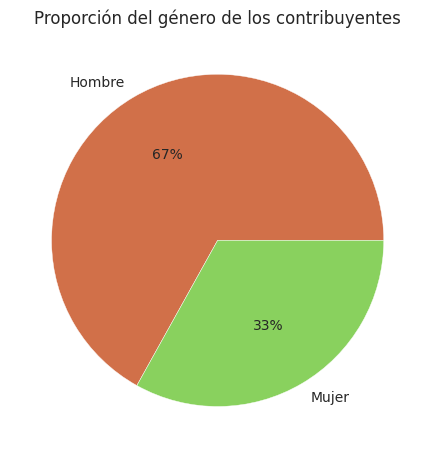

In [23]:
plt.figure(dpi=100)
cantidad_por_genero = df.genero.value_counts(normalize=True)
cantidad_por_genero.plot(kind='pie',labels= ['Hombre', 'Mujer'],colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title('Proporción del género de los contribuyentes')
plt.ylabel('')
plt.show()

Se observa una mayor cantidad de hombres. Una posible explicación, podria ser que, aún en los tiempos que corren, las mujeres continuan realizando mayormente tareas domesticas no remuneradas que les impide trabajar. Veamos si se evidencian algunas otras desigualdades

## ¿Hay igualdad de Genero en los valores adquisitivos declarados?

Muchas veces se menciona el hecho de que las mujeres suelen tener más obstaculos para llegar a ser mejor remuneradas. Veamos...

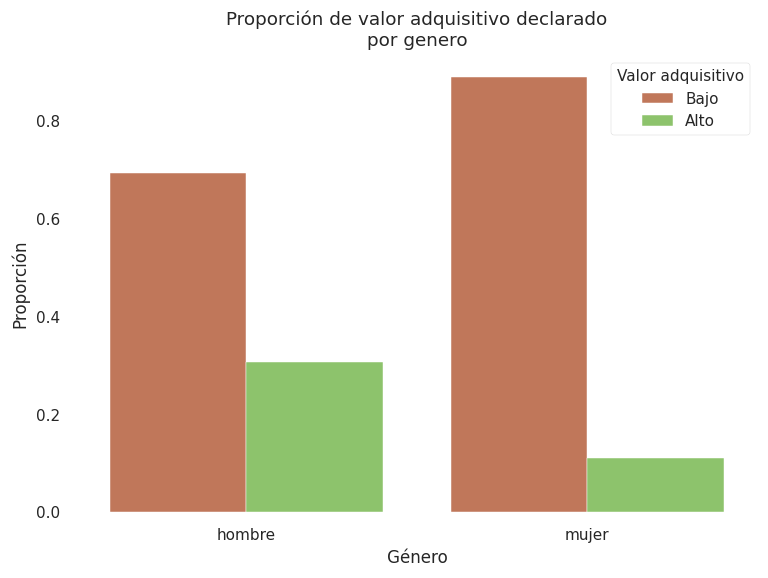

In [24]:
plt.figure(dpi = 110)
colors = ['#D17049', "#89D15E"]

bar_plot = sns.barplot(
    data=df.groupby("genero")
    .tiene_alto_valor_adquisitivo.value_counts(normalize=True)
    .rename("Proporción")
    .reset_index(),
    x='genero',
    y="Proporción",
    hue='tiene_alto_valor_adquisitivo',
    palette=colors,
)

bar_plot.set_xlabel("Género")
bar_plot.set_title("Proporción de valor adquisitivo declarado\npor genero")
#bar_plot.set_xticks(np.arange(0,1.1, 0.1))
leg = bar_plot.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.show()

Como podemos observar, no es para nada equitativa la posibilidad de tener alto valor adquisitivo. Osea que no solo hay más hombres, sino que estos tienen más chances de calificar como de alto valor adquisitivo. ¿Qué es lo que puede llevar a esto?



##  ¿El género  y el rol familiar influyen en las horas trabajadas?

Antes habiamos mencionado que una posibilidad de disparidad en cantidad de contribuyentes hombres y mujeres, era que aún estos tiempos era posible que más mujeres se ocupen solo de tareas domesticas. Pero ¿Y si esta tendencia se mantiene aún en aquellas mujeres que tiene un trabajo remunerado? Veamos primero como estan distribuidos los roles familiares

### ¿Cómo es la distribución de los roles familiares?

Para tener consistencia, vamos a juntar las categorias casado y casado en una sola 'casado_a', ya que por ejemplo en soltero no se hace esa distinción

In [25]:
casada_mujer_o_casado_hombre = (df.rol_familiar_registrado == 'casado' ) | (df.rol_familiar_registrado == 'casada') 
df['rol_familiar_registrado'].mask(casada_mujer_o_casado_hombre, 'casado_a', inplace=True)

Veamos ahora si, la distribución

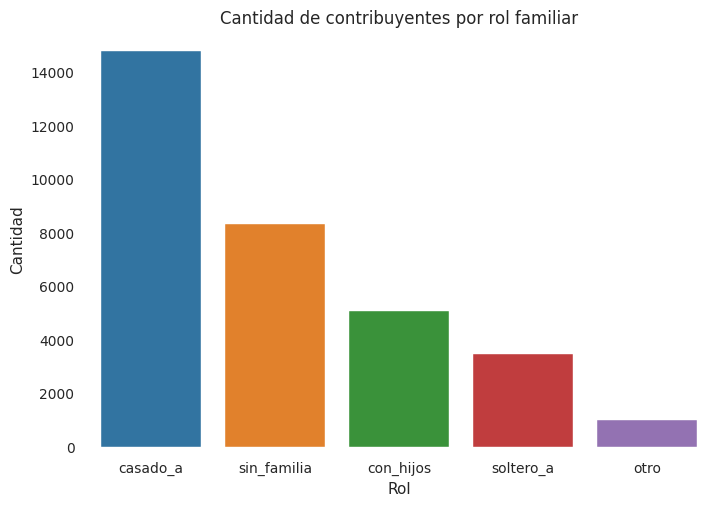

In [26]:
plt.figure(dpi = (100))
roles = df['rol_familiar_registrado']
a=sns.countplot(
   data=roles, x=roles.values, order = ['casado_a','sin_familia','con_hijos','soltero_a','otro']
)
a.set_title("Cantidad de contribuyentes por rol familiar")

plt.ylabel("Cantidad")
plt.xlabel("Rol")
plt.xticks(rotation=0)
plt.show()


Lo que observamos es que la mayoria de personas estan casadas y muchas también tienen hijos. Llama un poco la atención la cantidad sin familia, parece que hay más gente sola de la que pensabamos 

### Ahora si ¿Quienes trabajan más en promedio?

Observemos que sucede según género en cuanto a las horas trabajadas promedio. Sumemos el rol familiar para obtener más información

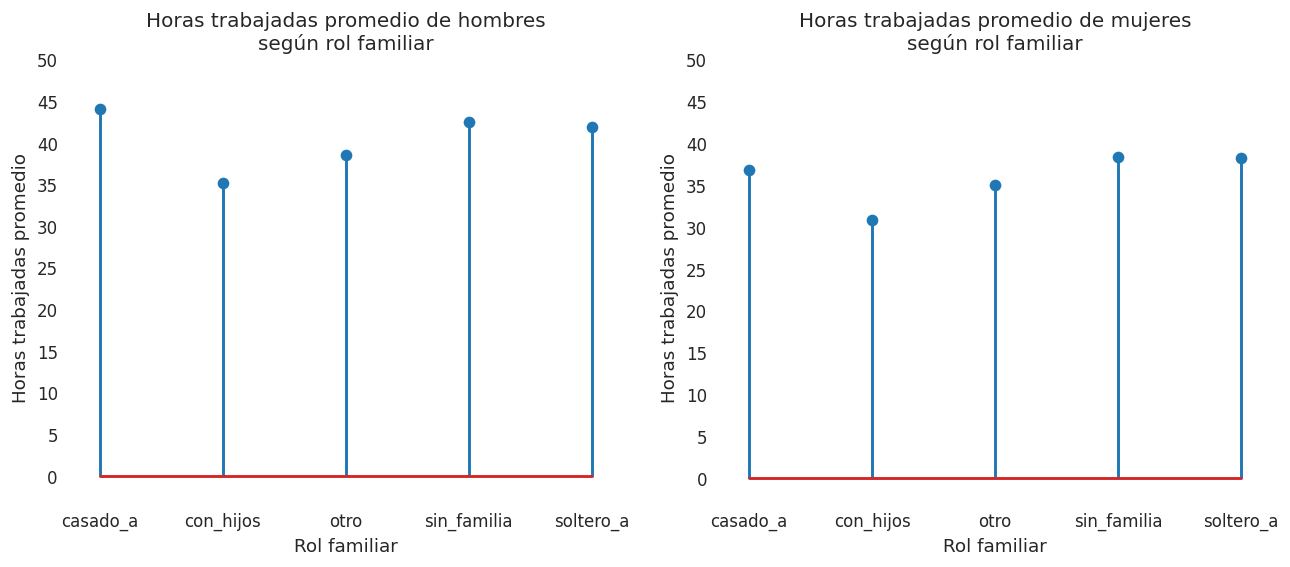

In [27]:
hombres = df[df.genero == 'hombre']
mujeres = df[df.genero == 'mujer']
hombres = hombres.groupby('rol_familiar_registrado').agg(list)
mujeres = mujeres.groupby('rol_familiar_registrado').agg(list)
hombres['horas_trabajadas_promedio'] = hombres['horas_trabajo_registradas'].apply(np.mean)
mujeres['horas_trabajadas_promedio'] = mujeres['horas_trabajo_registradas'].apply(np.mean)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)


ploted = axes[0].stem(hombres.index,hombres.horas_trabajadas_promedio,use_line_collection=True)
ploted2 = axes[1].stem(mujeres.index,mujeres.horas_trabajadas_promedio,use_line_collection=True)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:       
    plot[1].set_ylabel("Horas trabajadas promedio")
    plot[1].set_xlabel("Rol familiar") 
    plot[1].set_yticks(np.arange(0,55,5))

axes[0].set_title("Horas trabajadas promedio de hombres\nsegún rol familiar")
axes[1].set_title("Horas trabajadas promedio de mujeres\nsegún rol familiar")


plt.show()


En primer lugar, podemos observar que en todos los roles los hombres parecieran trabajar más en promedio. A su vez, es destacable que tanto para hombres como mujeres, este promedio baja considerablemente al tener hijos y de hecho la categoria con menos horas registradas es la de mujer con hijos. Quizás sea este un factor relevante a la hora de explicar la disparidad en las chances de tener alto poder adquisitivo. Pero no nos detengamos aca, continuemos

## Llegar a los mejores trabajos ¿Más complicado para las mujeres?

Muchas veces se menciona dificultad para las mujeres a la hora de acceder a puestos de renombre. Grafiquemos

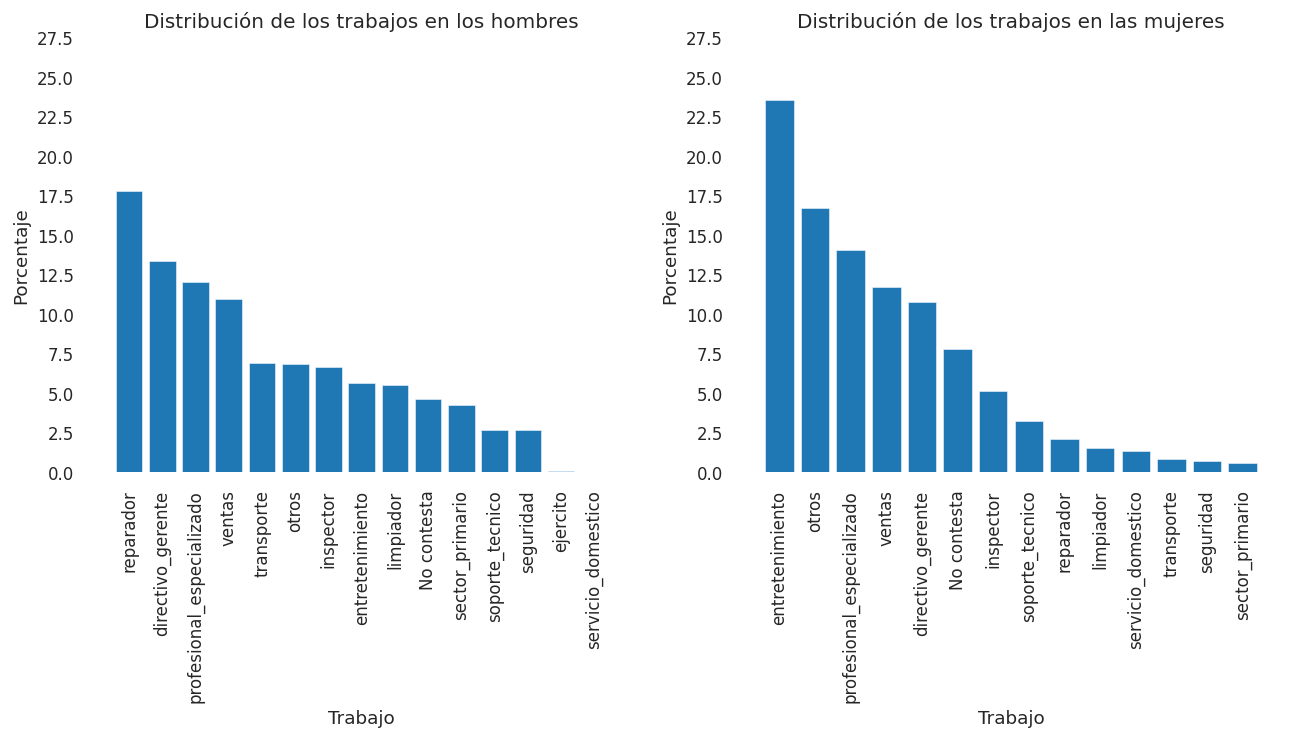

In [28]:
hombres = df[df.genero == 'hombre']
mujeres = df[df.genero == 'mujer']
trabajos_hombres = hombres.trabajo.value_counts(normalize=True)*100
trabajos_mujeres = mujeres.trabajo.value_counts(normalize=True)*100
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)


ploted = axes[0].bar(trabajos_hombres.index,trabajos_hombres.values)
ploted2 = axes[1].bar(trabajos_mujeres.index,trabajos_mujeres.values)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:       
    plot[1].tick_params('x',labelrotation=90)
    plot[1].set_ylabel("Porcentaje")
    plot[1].set_xlabel("Trabajo") 
    plot[1].set_yticks(np.arange(0,30,2.5))


axes[0].set_title("Distribución de los trabajos en los hombres")
axes[1].set_title("Distribución de los trabajos en las mujeres")

plt.show()


Si bien hay un buen porcentaje de mujeres que se dedica al rubro del entretenimiento y otros trabajos, porcentualmente pareciera que las mujeres no tienen más problemas para llegar a ser profesionales o gerentes. ¿Será entonces que reciben menos por los mismos trabajos?  

Bueno, suficiente con el tema género. Vayamos ahora a otro tópico muy mencionado en el último tiempo

# Con la democracia se come, se cura y ¿Se educa?


Analizaremos un poco las variables referidas a la educación, ya que creemos que podria ser una caracteristica importante de los contribuyentes


## ¿Los contribuyentes tienen elevada cantidad de años estudiados?


Veamos cuantos años pasaron en las aulas 

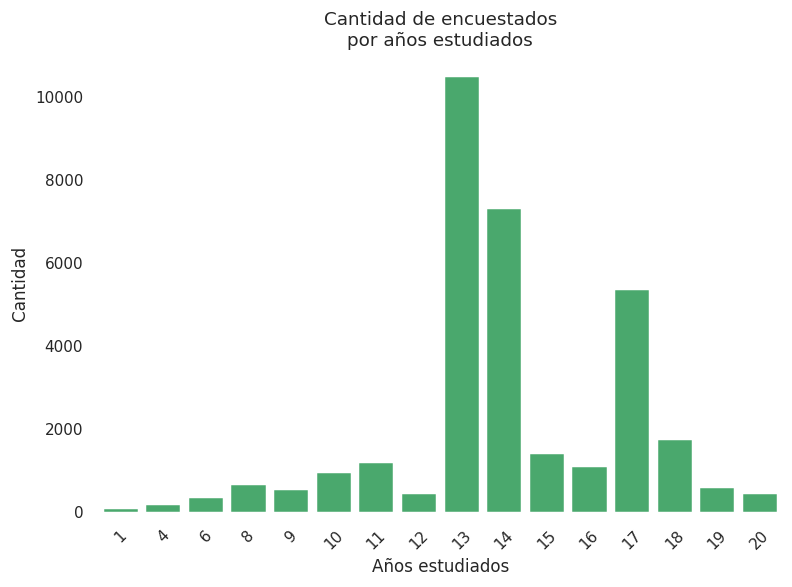

In [29]:
fig, ax = plt.subplots(dpi=110)

sns.countplot(
    x="anios_estudiados",
    data=df,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Años estudiados")
plt.title("Cantidad de encuestados\npor años estudiados")
plt.xticks(rotation=45)
plt.show()



Podemos concluir en que hay una gran cantidad de personas que han estudiado entre 13 y 14 años, como tambien una buena cantidad de personas que estudiaron 17 años. 

Esta elevada cantidad de personas con dichos años estudiados tiene sentido ya que la gran mayoria tarda entre 13 y 14 años en terminar la secundaria, y aquellos que deciden estudiar una carrera universitaria podrian tardar 17 años en promedio segun se puede interpretar de estos gráficos. Confirmemosló


## La gran mayoria ¿Terminó la secundaria? ¿Se quedó ahí?

No es una obligatoriedad elegir una carrera universitaria una vez finalizado el nivel secundario, por lo que podriamos llegar a ver que predomine una gran mayoria de personas que alcanzó como maximo nivel el de educación secundaria.

Antes de empezar, veamos la cantidad de niveles educativos registrados

In [30]:
print("Hay un total de", df.educacion_alcanzada.nunique(), "niveles educativos registrados")
df.educacion_alcanzada.value_counts()

Hay un total de 16 niveles educativos registrados


4_anio                10501
5_anio                 7291
universidad_3_anio     5355
universidad_4_anio     1723
universidad_1_anio     1382
2_anio                 1175
universidad_2_anio     1067
1_anio                  933
7-8_grado               646
universiada_5_anio      576
9_grado                 514
3_anio                  433
universiada_6_anio      413
5-6_grado               333
1-4_grado               168
preescolar               51
Name: educacion_alcanzada, dtype: int64

Para responder nuestra pregunta nos seria más sencillo dividr este espacio reduciendo la cardinalidad, agrupado en pares de grados/años segén el nivel educativo descripto

In [31]:
def agrupacion_educacion(categoria):
    if categoria in ['universidad_4_anio','universiada_5_anio','universiada_6_anio']:
        return 'Universitario - (3,6] anio'
    if categoria in ['universidad_1_anio','universidad_2_anio','universidad_3_anio']:
        return 'Universitario - [1,3] anio'
    if categoria in ['1_anio','2_anio','3_anio']:
        return 'Secundario - [1,3] anio'
    if categoria in ['4_anio','5_anio','6_anio']:
        return 'Secundario - (3,6] anio'
    if categoria in ['1-4_grado','5-6_grado']:
        return 'Primaria - [1,6] grado'
    if categoria in ['7-8_grado','9_grado']:
        return 'Primaria - (6,9] grado'
    if categoria in ['preescolar']:
        return 'Jardin'    
    return categoria


df['educacion_alcanzada_agrupada'] = df.educacion_alcanzada.apply(agrupacion_educacion)

Con esto nos quedaría:

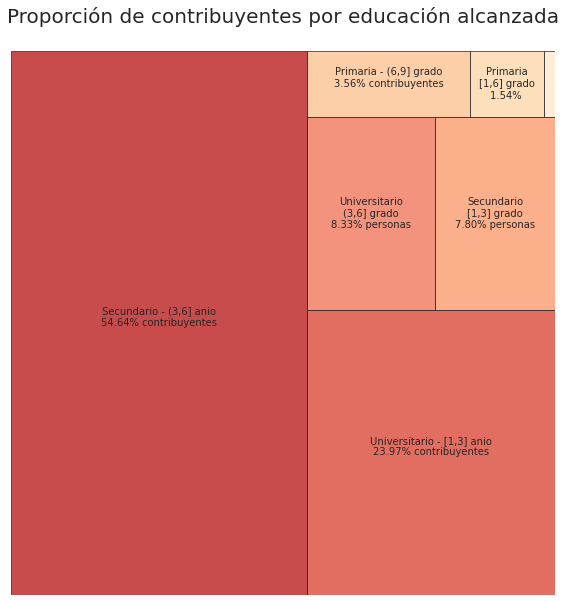

In [32]:
pd.options.mode.chained_assignment = None
padding = 0.001 # la buena técnica de relleno, nada le gana
df2 = df['educacion_alcanzada_agrupada'].value_counts(normalize=True).to_frame().reset_index().rename(columns={'educacion_alcanzada_agrupada': 'Cantidad'}).rename(columns={'index':'educacion_alcanzada_agrupada'})
df2_modificated = df2.copy()
df2_modificated.Cantidad = df2_modificated.Cantidad+padding
df2.loc[0].Cantidad = df2.loc[0].Cantidad - float(padding)

colors = ['#00aae4', '#5ab8e9', '#84c6ed', '#a6d4f2', '#c5e2f6', '#e2f0fb', '#e2f0fb']
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, aspect="equal")
labels = ["%s\n%1.2f%% contribuyentes\n" % (label) for label in zip(df2['educacion_alcanzada_agrupada'], df2.Cantidad*100)]
labels[6]=' '

labels[5] = "Primaria\n[1,6] grado\n%1.2f%% " % (df2["Cantidad"][5]*100)
labels[3] = "Secundario\n[1,3] grado\n%1.2f%% personas" % (df2['Cantidad'][3]*100)
labels[2] = "Universitario\n(3,6] grado\n%1.2f%% personas" % (df2['Cantidad'][2]*100)

ax = squarify.plot(df2_modificated.Cantidad, alpha=.7, label=labels,ax=ax,color=(sns.color_palette("OrRd_r", 7)), bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Proporción de contribuyentes por educación alcanzada\n", fontsize=20)
plt.show()

Lo cual podemos confirmar lo que esperabamos; una gran mayoria termina, o  se queda, solamente con nivel educativo máximo el secundario. Aunque la proporción de universitarios (32%) total es esperanzadora para la población, y no es una proporción poco significativa al total tal como lo es la primaria

## ¿Se graduan la misma proporción de generos?

Manteniendo la misma particion de niveles educativos, nos parece interesante ver si hay igualdad en cuanto a género con el nivel educativo alcanzado.

Utilizado incluso el mismo grafico anterior, separemos según hombres y mujeres registradas

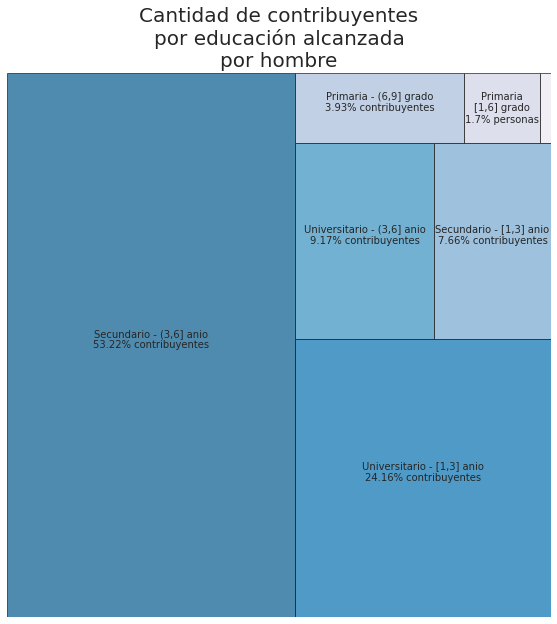

In [33]:
def graficar_treemap_educacion_por_genero(genero,color):

    padding = 0.001 # la buena técnica de relleno, nada le gana

    df2 = df[(df.genero==genero)]['educacion_alcanzada_agrupada'].value_counts(normalize=True).to_frame().reset_index().rename(columns={'educacion_alcanzada_agrupada': 'Cantidad'}).rename(columns={'index':'educacion_alcanzada_agrupada'})
    df2_modificated = df2.copy()
    df2_modificated.Cantidad = df2_modificated.Cantidad+padding
    df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] = df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] - padding


    colors = ['#00aae4', '#5ab8e9', '#84c6ed', '#a6d4f2', '#c5e2f6', '#e2f0fb', '#e2f0fb']
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, aspect="equal")
    labels = ["%s\n%1.2f%% contribuyentes\n" % (label) for label in zip(df2['educacion_alcanzada_agrupada'], df2.Cantidad*100)]
    labels[6]=' '

    labels[5] = "Primaria\n[1,6] grado\n%1.1f%% personas" % (df2["Cantidad"][5]*100)

    ax = squarify.plot(df2_modificated.Cantidad, alpha=.7, label=labels,ax=ax,color=(sns.color_palette(color, 7)), bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Cantidad de contribuyentes por educación alcanzada\n", fontsize=20)

    title = "Cantidad de contribuyentes\npor educación alcanzada\npor " + genero
    ax.set_title(title, fontsize=20)
    plt.show()
    
graficar_treemap_educacion_por_genero("hombre","PuBu_r")

Veamos en el caso de las mujeres


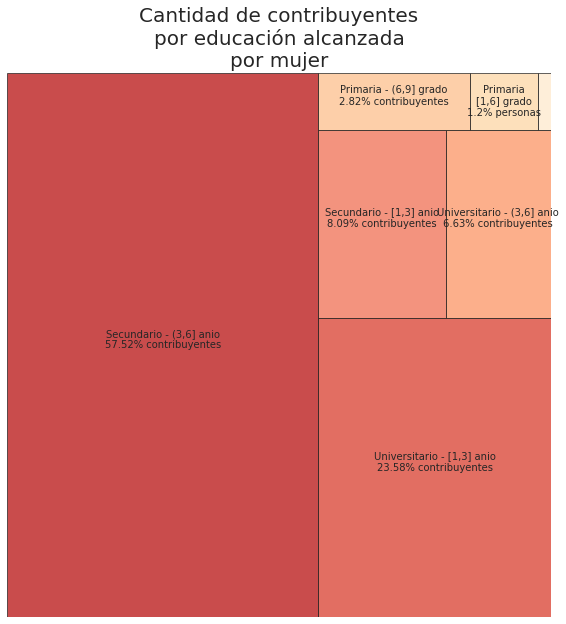

In [34]:
graficar_treemap_educacion_por_genero("mujer","OrRd_r")

En los gráficos podemos observar que no hay gran diferencia en la educación alcanza según género

## ¿Hay relación con el valor adquisitivo segun los años estudiados y nivel educativo alcanzado?

Dividamos y grafiquemos

In [35]:
def agrupacion_anios_estudiados(categoria):
    if categoria in np.arange(1,6).tolist():
        return '(0,5]'
    if categoria in np.arange(6,9).tolist():
        return '(5,8]'
    if categoria in np.arange(9,12).tolist():
        return '(8,11]'
    if categoria in np.arange(12,15).tolist():
        return '(11,14]'
    if categoria in np.arange(15,18).tolist():
        return '(14,17]'
    if categoria in np.arange(18,21).tolist():
        return '(17,20]'
    return categoria


df['Anios estudiados generalizada'] = df.anios_estudiados.apply(agrupacion_anios_estudiados)

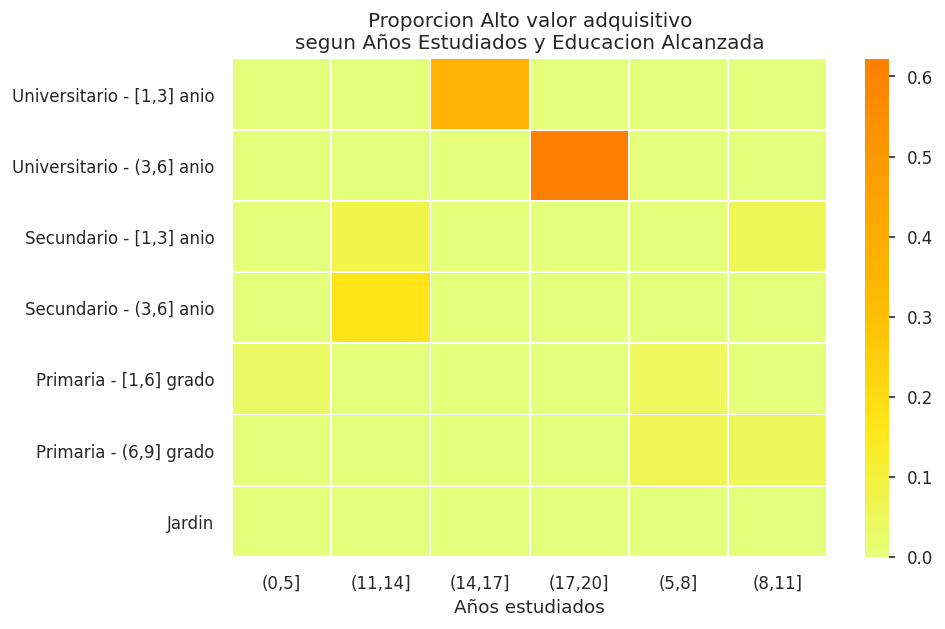

In [36]:
plt.figure(dpi=120)
pivoted_years = pd.pivot_table(
    data = df, 
    index ='educacion_alcanzada_agrupada', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted_years.sort_index(ascending =  False, inplace = True)
pivoted_years = pivoted_years.replace(np.nan,0)
g = sns.heatmap(pivoted_years, cmap="Wistia", linewidths=.5)
g.set_ylabel("")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion Alto valor adquisitivo\nsegun Años Estudiados y Educacion Alcanzada")

plt.show()

Vemos que quienes llegan a los últimos años en la universidad tienen una alta proporción de calificar como de altos ingresos. Esto será significativo a futuro, al momento de predecir quienes tienen alto valor adquisitivo

Y ya que hablamos de plata...

# Buscando al lobo de Wall Street Argentino

Cuando se tiene tiempo libre, cuando se dispone de capital o a veces por mera curiosidad, los trabajadores recurren a la bolsa a ver si se puede ganar algo más de dinero del que les da su actividad principal. Veamos que proporción de contribuyentes operan en la bolsa Argentina. Vamos a tener en cuenta que es raro que quién opere en este tipo de activo financiero tenga un balance que le de justo cero, **por lo que consideraremos que estos contribuyentes no operan en la bolsa**

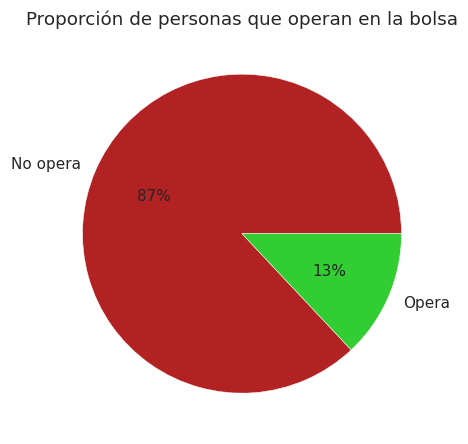

In [37]:
plt.figure(figsize=(6.4, 4.8), dpi=110)
plt.title('Proporción de personas que operan en la bolsa')
plt.pie((df['suma_declarada_bolsa_argentina'] != 0).value_counts(), labels= ['No opera', 'Opera'], colors=["firebrick",'limegreen'],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

El gráfico es concluyente, el 13% de los contribuyentes del dataset provisto operan en la bolsa

## ¿Qué tal le va a la gente inviertiendo en la bolsa?

Amada por algunos y defenestrada por otros, la inversión en la bolsa puede ser tocar el cielo con las manos o el comienzo de la bancarrota. Observemos

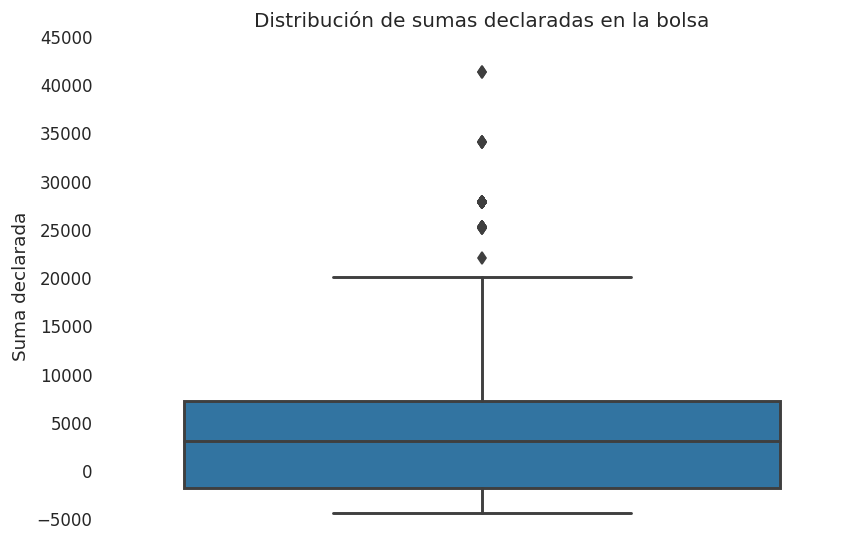

In [38]:
plt.figure(dpi=120)
outlier_quitado = (df.suma_declarada_bolsa_argentina != 99999)
los_que_operan = df[(df.suma_declarada_bolsa_argentina != 0) & outlier_quitado]
plt.title("Distribución de sumas declaradas en la bolsa")
sns.boxplot(
    data=los_que_operan,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-5000,50000,5000))
plt.ylabel("Suma declarada")

plt.show()

En primer lugar, lo que se observa es que no hay grandisimas ganancias (si los valores estan en pesos) por parte de los bolseros. En segundo Lugar, tampoco pareciera haber muchas perdidas. Si se pueden observar algunos casos excepcionales (outliers) de personas que realmente logran triunfar con sus inversiones

## ¿Hay algún estado marital que favorezca el interés por operar en la bolsa?

Por nuestra propia experiencia, muchos solteros/as acuden a la bolsa al no tener en donde invertir sus ahorros (y además poder ahorrar más). Veamos si esto es asi

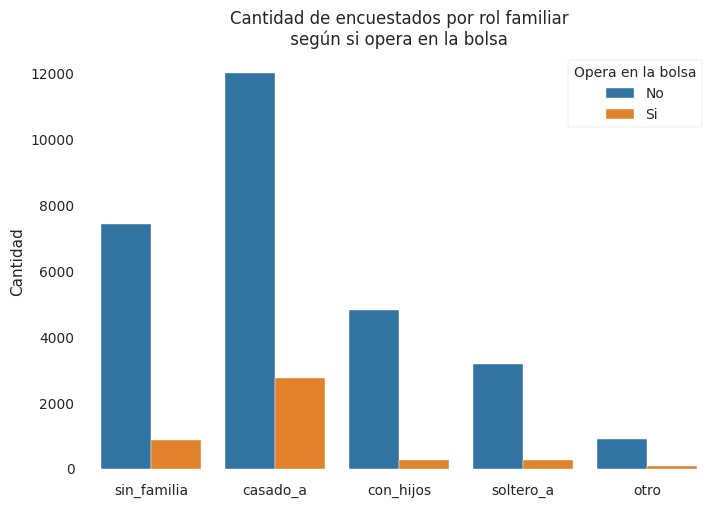

In [39]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='rol_familiar_registrado', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No','Si'],title='Opera en la bolsa')
plt.ylabel("Cantidad")
plt.xlabel(" ")
plt.title("Cantidad de encuestados por rol familiar\n según si opera en la bolsa ")
plt.show()

Contrariamente a lo pensado, el mayor porcentaje de inversores en la bolsa se da en gente casada. Sin embargo, al momento de observar a quienes tienen hijos, se ve una disminución muy fuerte de gente inviertiendo en la bolsa. Esto puede deberse a que quizás, la gente prefiere tener el dinero ahorrado, sin generar interés pero también sin generar una posible perdida

## Tener alto valor adqusitivo ¿Sinónimo de operar en la bolsa?

Dijimos en la introducción a este segmento, que mucha gente recurre a la bolsa por tener capacidad de ahorro y no querer tener inmovilizado ese dinero. Grafiquemos

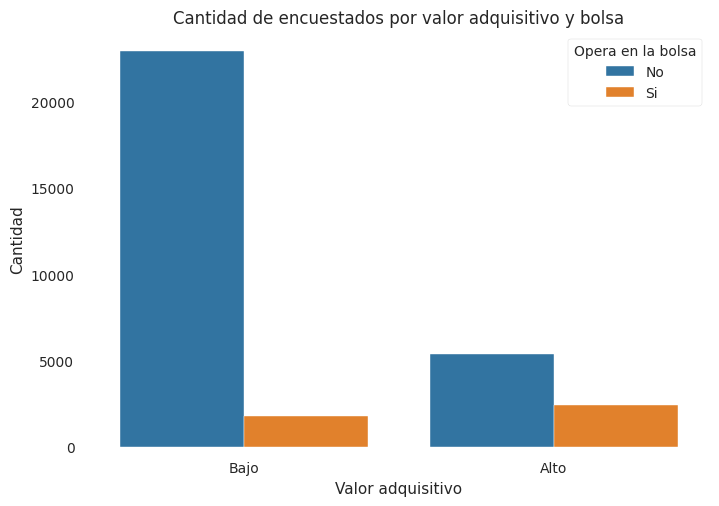

In [40]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='tiene_alto_valor_adquisitivo', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No','Si'],title='Opera en la bolsa')
plt.ylabel("Cantidad")
plt.xlabel("Valor adquisitivo")
plt.title("Cantidad de encuestados por valor adquisitivo y bolsa")
plt.xticks([False, True], ["Bajo", "Alto"])
plt.show()

Se observa una mayor tendencia a operar en la bolsa por parte de contribuyentes de altos ingresos, más del 30% tiene alguna suma declarada. La tendencia disminuye drásticamente para contribuyentes de bajos ingresos. ¿Y si una de las claves del éxito esta en las acciones? Prosigamos 

### Tienen alto poder adquisitivo y operan en la bolsa ¿Ganan?

Veamos la distribución

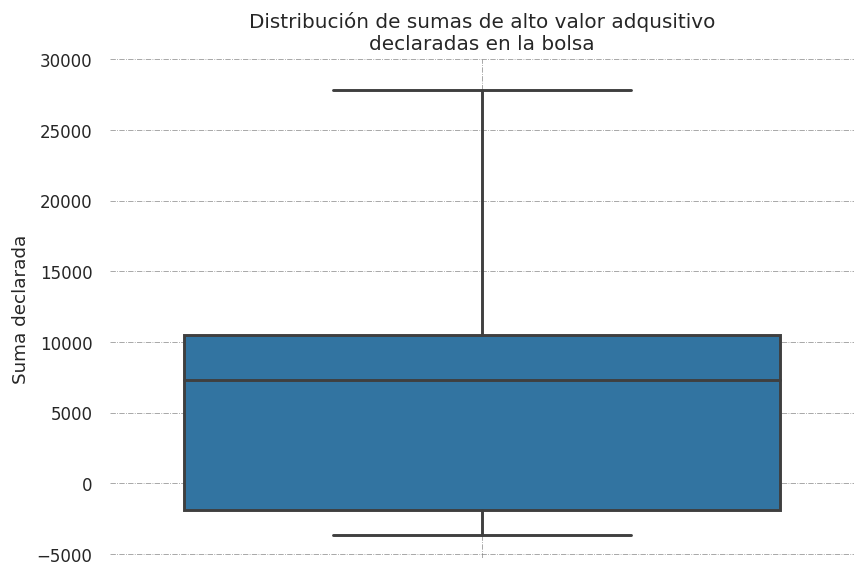

In [41]:
plt.figure(dpi=120)
outlier_quitado = (df.suma_declarada_bolsa_argentina != 99999)

los_que_operan_y_alto = df[(df.suma_declarada_bolsa_argentina != 0) & (df.tiene_alto_valor_adquisitivo == 1) & outlier_quitado]
plt.title("Distribución de sumas de alto valor adqusitivo\ndeclaradas en la bolsa")
sns.boxplot(
    data=los_que_operan_y_alto,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-5000,35000,5000))
plt.ylabel("Suma declarada")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)

plt.show()

Notable, un alto porcentaje de quienes tienen altos ingresos ganan en la bolsa. Pero bueno, esto en sí no nos dice mucho, veamos la otra cara de la moneda


### Tienen bajo poder adquisitivo y operan en la bolsa ¿Pierden?

Grafiquemos

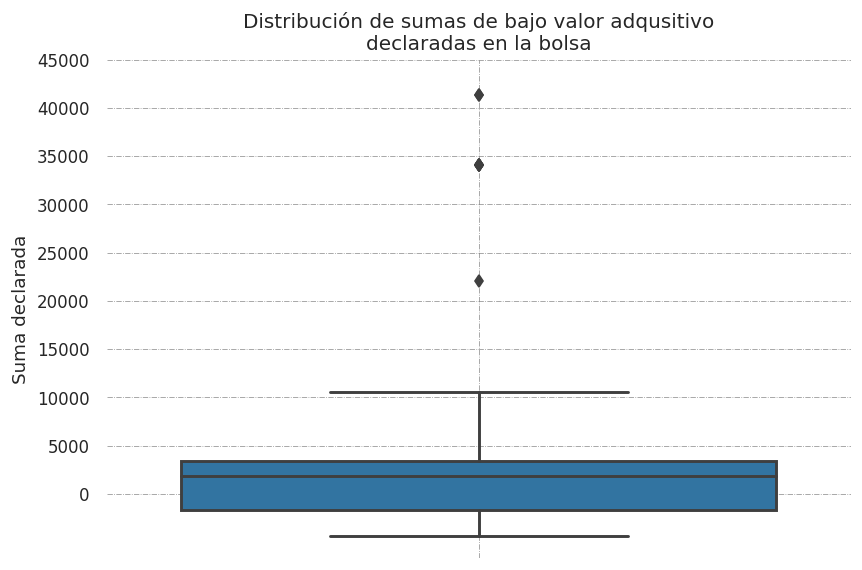

In [42]:
plt.figure(dpi=120)
los_que_operan_y_bajo = df[(df.suma_declarada_bolsa_argentina != 0) & (df.tiene_alto_valor_adquisitivo == 0)]
plt.title("Distribución de sumas de bajo valor adqusitivo\ndeclaradas en la bolsa")
sns.boxplot(
    data=los_que_operan_y_bajo,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(0,50000,5000))
plt.ylabel("Suma declarada")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)

plt.show()

Es notable, la gran diferencia se ve en los montos que ganan los de bajo poder adquisitivo. Basta comparar el máximo aquí con el del gráfico anterior. Mención especial a unos pocos outliers

Bueno, hasta aquí con la bolsa. Ya hablamos de varias cosas y si bien en el camino fuimos recolectando información al respecto, llego la hora de ir al grano

# Los ricos no piden permiso

Venimos de identificar una interesante relación entre el alto valor adquisitivo y la bolsa. Ya habiamos visto antes la influencia de la edad, del género, de la educación e incluso los trabajos que son propensos a tener más dinero. Profundizemos

## Sector público vs Sector privado ¿Afecta la categoría de trabajo al nivel de ingresos?

Algunos sostienen que en el Estado se gana más, pero hemos escuchado que el sector privado aún se mantiene fuerte. ¿Será mejor estar en relación de dependencia? ¿O mejor ser monotributista/responsable inscripto? Grafiquemos, teniendo en cuenta también el trabajo

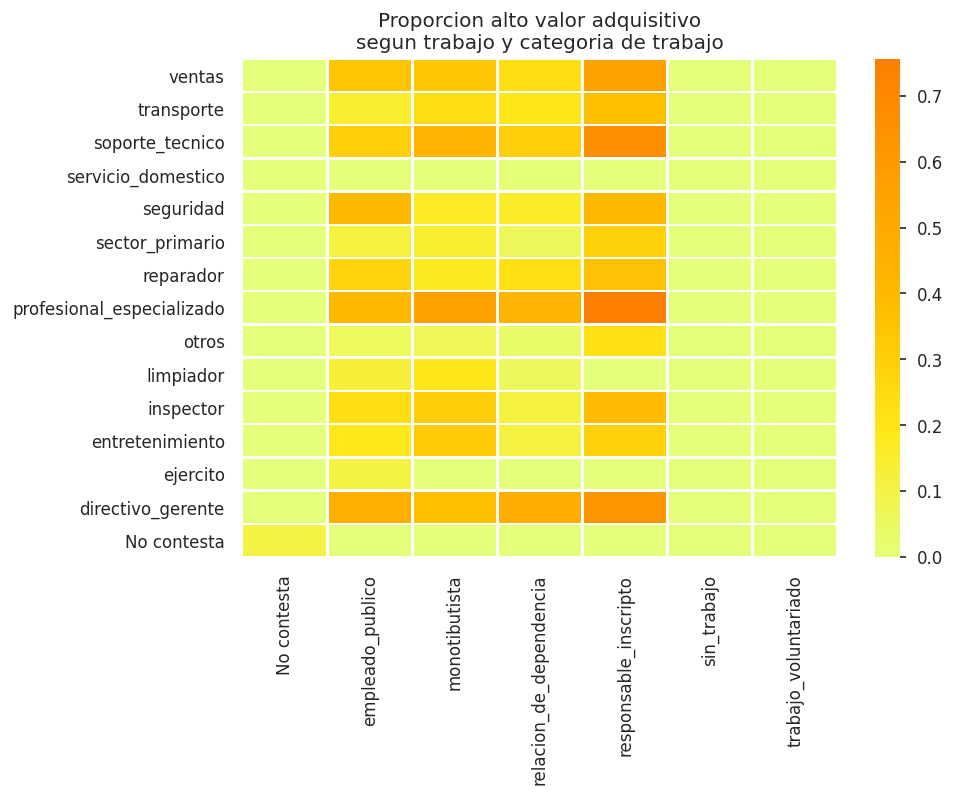

In [43]:
plt.figure(dpi=120)
pivoted_years = pd.pivot_table(
    data = df, 
    index ='trabajo', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'categoria_de_trabajo',
)
pivoted_years.sort_index(ascending =  False, inplace = True)
pivoted_years = pivoted_years.replace(np.nan,0)
g = sns.heatmap(pivoted_years, cmap="Wistia", linewidths=.9)
g.set_ylabel("")
g.set_xlabel("")
g.set_title("Proporcion alto valor adquisitivo\nsegun trabajo y categoria de trabajo")

plt.show()

La categoria que pareciera presentar más contribuyentes de altos ingresos pareciera ser responsable inscripto. También, en los trabajos que ya habiamos identificado como importantes, independentiemente de la categoria de trabajo, observamos tendencia a calificar como de altos ingresos 

## La religión ¿Determinante?

Aún no habiamos introducido esta variable, grafiquemos su distribución

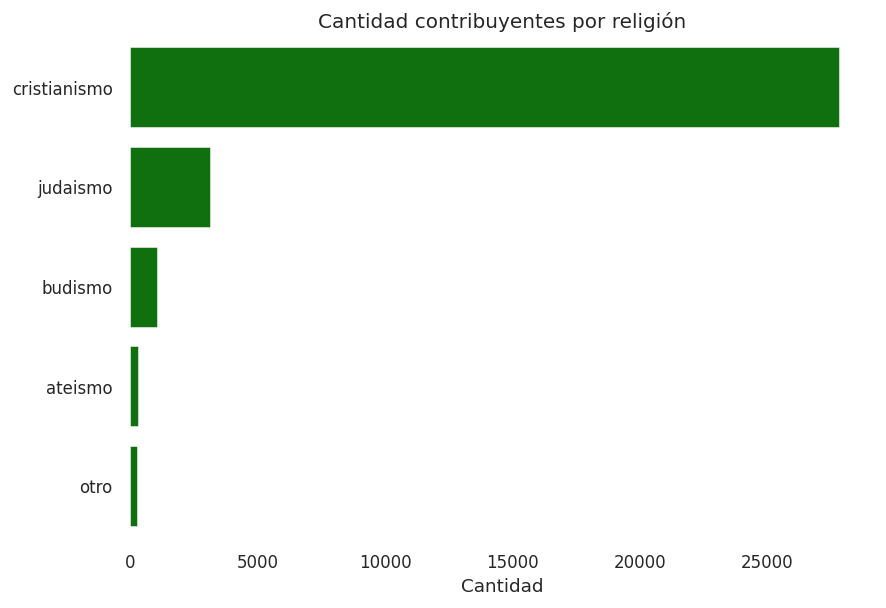

In [44]:
f, ax = plt.subplots(dpi = 120)
g = sns.countplot(y="religion", data=df, color="g")
g.set_ylabel("")
g.set_xlabel("Cantidad")
plt.xticks(np.arange(0,30000,5000))
plt.title("Cantidad contribuyentes por religión")
plt.show()

Interesante... la gran mayoria de contribuyentes es cristiano. Ahora si, veamos si esto influye 

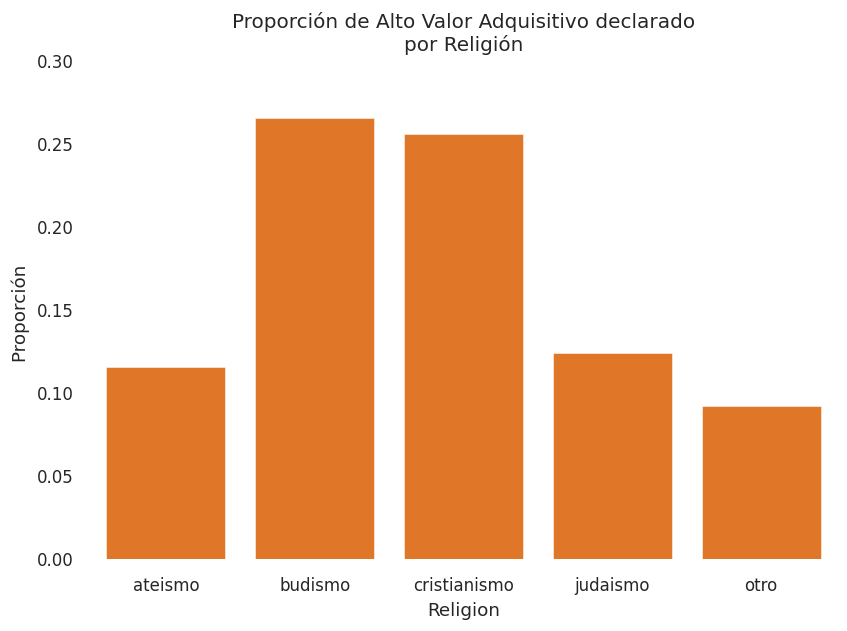

In [45]:
plt.figure(dpi = 120)

bar_plot = sns.barplot(
    data=df.groupby("religion").agg({'tiene_alto_valor_adquisitivo': 'mean'}).reset_index(),
    x='religion',
    y="tiene_alto_valor_adquisitivo",color="#FF7208"
)

bar_plot.set_xlabel("Religion")
bar_plot.set_ylabel("Proporción ")
bar_plot.set_title("Proporción de Alto Valor Adquisitivo declarado\npor Religión")
bar_plot.set_yticks(np.arange(0,0.35, 0.05))
plt.show()

Percibimos que solamente en el judaismo y en el ateismo se modifica la tendencia general respecto a los ingresos. Aún asi, no pareciera ser un factor determinante la religión

## Casarse ¿Implica mayores chances?

Habiamos visto que los casados invertian considerablemente en la bolsa, ¿Qué sucede con sus ingresos? 

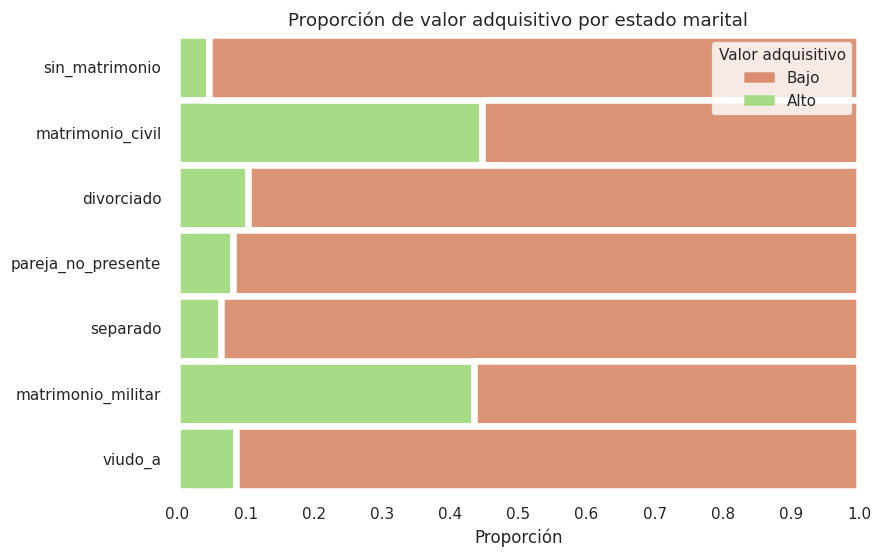

In [46]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='estado_marital',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto") 
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

El gráfico es claro, estar en un matrimonio pareciera favorecer el valor adquisitivo

### Profundizando

Vimos que estar en matrimonio es una condición favorable a tener alto valor adquisitivo. También, sabiamos que los años estudiados y los trabajos eran factores determinantes. Veamos si trabajando en el subespacio de gente que contrajo matrimonio civil podemos hayar mas información

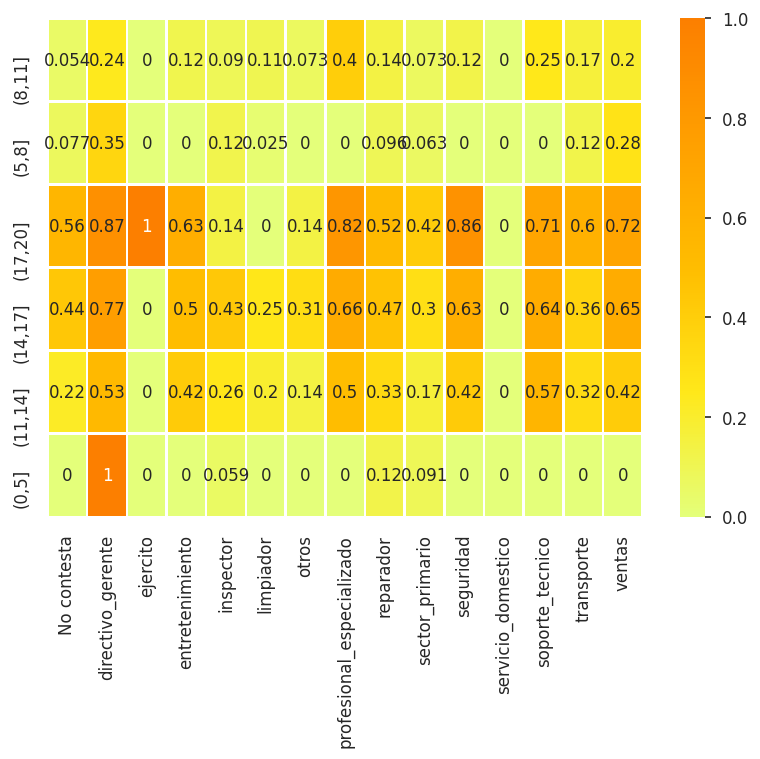

In [47]:
plt.figure(dpi=120)
pf = df[df.estado_marital == 'matrimonio_civil']
pivoted_years = pd.pivot_table(
    data = pf, 
    index ='Anios estudiados generalizada', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'trabajo',
)
pivoted_years.sort_index(ascending =  False, inplace = True)
pivoted_years = pivoted_years.replace(np.nan,0)
g = sns.heatmap(pivoted_years, cmap="Wistia", linewidths=.9,annot=True)
g.set_ylabel("")
g.set_xlabel("")
g.set_title("")

plt.show()

Los resultados son claros, en la gran mayoria de personas que estudiaron 17 o más años y esta casada, se observa una tendencia a tener un alto valor adquisitivo

#  Baseline

En base a todo lo desarrollado anteriormente, desarrollamos el baseline pedido

In [48]:
df_cleaned = pd.read_csv("fiufip_dataset.csv")

In [49]:
def baseline(df: pd.DataFrame): #-> List[int]
    #Condiciones
    bolsa = df_cleaned.ganancia_perdida_declarada_bolsa_argentina > 7000    # 6.3.1/6.3.2
    anios_estudiados = df_cleaned.anios_estudiados > 16                     # 7.3.1
    matrimonio_civil = df_cleaned.estado_marital == 'matrimonio_civil'      # 7.3.1     
    
    predict_final = (bolsa) | (anios_estudiados & matrimonio_civil) 

    return list(predict_final.replace(True,1))
    
df_prediction = baseline(df_cleaned)
print('Accuracy:', accuracy_score(df_cleaned.tiene_alto_valor_adquisitivo, df_prediction).round(6)*100)

Accuracy: 84.1528
